In [614]:
!pip list

Package            Version
------------------ ---------
certifi            2025.1.31
charset-normalizer 3.4.1
colorama           0.4.6
idna               3.10
kagglehub          0.3.11
packaging          24.2
pip                25.0.1
PyYAML             6.0.2
requests           2.32.3
tqdm               4.67.1
urllib3            2.3.0


In [615]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

import warnings
warnings.filterwarnings("ignore")

In [616]:
khus_calclaims_path = kagglehub.dataset_download("khusheekapoor/vehicle-insurance-fraud-detection")

print(khus_calclaims_path)

C:\Users\timdi\.cache\kagglehub\datasets\khusheekapoor\vehicle-insurance-fraud-detection\versions\1


In [617]:
khus_calclaims_df = pd.read_csv(khus_calclaims_path + "/carclaims.csv")
khus_calclaims_df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [618]:
khus_calclaims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

# Features cleaning
Month, WeekOfMonth and DayOfWeek are the date of the activation of police
Unnecessary info due to we don't know when the police was bought

Same for date of claim

AccidentArea is unusefull cause it's USA only places. Instead my aim is Russia

PolicyNumber is unusefull also - all numbers are unique and it's nohow related to claims


In [619]:
len(khus_calclaims_df["PolicyNumber"].unique()) / len(khus_calclaims_df)

1.0

In [620]:
unusefull_columns = [
    "Month",
    "WeekOfMonth",
    "DayOfWeek",
    "AccidentArea",
    "DayOfWeekClaimed",
    "MonthClaimed",
    "WeekOfMonthClaimed",
    "PolicyNumber",
    "Year"
]

khus_calclaims_df.drop(unusefull_columns, axis=1, inplace=True)

In [621]:
khus_calclaims_df["Make"].unique()

array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
       'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab',
       'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus'],
      dtype=object)

In [622]:
MAKE_RIGHT_RENAME = {"Accura": "Acura", "Nisson": "Nissan", "Porche": "Porsche", "Mecedes": "Mercedes"}

khus_calclaims_df["Make"] = khus_calclaims_df["Make"].replace(MAKE_RIGHT_RENAME)

In [623]:
khus_calclaims_df["Make"].unique()

array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
       'Acura', 'Dodge', 'Mercury', 'Jaguar', 'Nissan', 'VW', 'Saab',
       'Saturn', 'Porsche', 'BMW', 'Mercedes', 'Ferrari', 'Lexus'],
      dtype=object)

In [624]:
khus_calclaims_df["PolicyType"].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

In [625]:
KHUS_POLICY_TYPE = {"Liability": "total", "Collision": "damage", "All Perils": "full"}


def policy_type_rename(x: str):
    return KHUS_POLICY_TYPE[x.split(" - ")[1]]


khus_calclaims_df["PolicyType"] = khus_calclaims_df["PolicyType"].apply(policy_type_rename)

In [626]:
khus_calclaims_df["PolicyType"].unique()

array(['total', 'damage', 'full'], dtype=object)

In [627]:
khus_calclaims_df["VehiclePrice"].unique()

array(['more than 69,000', '20,000 to 29,000', '30,000 to 39,000',
       'less than 20,000', '40,000 to 59,000', '60,000 to 69,000'],
      dtype=object)

In [628]:
KHUS_VEHICLE_PRICE = {
    "more than 69,000": 75000,
    "20,000 to 29,000": 25000,
    "30,000 to 39,000": 35000,
    "less than 20,000": 10000,
    "40,000 to 59,000": 50000,
    "60,000 to 69,000": 65000
}

khus_calclaims_df["VehiclePrice"] = khus_calclaims_df["VehiclePrice"].replace(KHUS_VEHICLE_PRICE)

In [629]:
khus_calclaims_df["VehiclePrice"].unique()

array([75000, 25000, 35000, 10000, 50000, 65000], dtype=int64)

In [630]:
KHUS_SUPPLIMENTS = {"none": 0, "1 to 2": 1, "3 to 5": 4, "more than 5": 6}

khus_calclaims_df["NumberOfSuppliments"] = khus_calclaims_df["NumberOfSuppliments"].replace(KHUS_SUPPLIMENTS)

In [631]:
khus_calclaims_df["NumberOfSuppliments"].unique()

array([0, 6, 4, 1], dtype=int64)

In [632]:
khus_calclaims_df["AgeOfPolicyHolder"].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

In [633]:
KHUS_AGE_OF_HOLDER = {
    "26 to 30": 28,
    "31 to 35": 33,
    "41 to 50": 46,
    "51 to 65": 57,
    "21 to 25": 23,
    "36 to 40": 38,
    "16 to 17": 17,
    "over 65": 70,
    "18 to 20": 19
}


def age_of_holder_rename(x: str):
    return KHUS_AGE_OF_HOLDER[x]


khus_calclaims_df["AgeOfPolicyHolder"] = khus_calclaims_df["AgeOfPolicyHolder"].apply(age_of_holder_rename)

In [634]:
khus_calclaims_df["AgeOfPolicyHolder"].unique()

array([28, 33, 46, 57, 23, 38, 17, 70, 19], dtype=int64)

In [635]:
khus_calclaims_df["AgeOfVehicle"].unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

In [636]:
KHUS_AGE_OF_VEHICLE = {
    "3 years": 3,
    "6 years": 6,
    "7 years": 7,
    "more than 7": 9,
    "5 years": 5,
    "new": 0,
    "4 years": 4,
    "2 years": 2
}

khus_calclaims_df["AgeOfVehicle"] = khus_calclaims_df["AgeOfVehicle"].replace(KHUS_AGE_OF_VEHICLE)

In [637]:
khus_calclaims_df["AgeOfVehicle"].unique()

array([3, 6, 7, 9, 5, 0, 4, 2], dtype=int64)

In [638]:
khus_calclaims_df["NumberOfCars"].unique()

array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
      dtype=object)

In [639]:
KHUS_NUMBER_CARS = {"1 vehicle": 1, "2 vehicles": 2, "3 to 4": 3, "5 to 8": 6, "more than 8": 9}

khus_calclaims_df["NumberOfCars"] = khus_calclaims_df["NumberOfCars"].replace(KHUS_NUMBER_CARS)

In [640]:
khus_calclaims_df["NumberOfCars"].unique()

array([3, 1, 2, 6, 9], dtype=int64)

In [641]:
khus_calclaims_df["BasePolicy"].unique()

array(['Liability', 'Collision', 'All Perils'], dtype=object)

In [642]:
KHUS_BASE_POLICY = {"Liability": "total", "Collision": "damage", "All Perils": "full"}

khus_calclaims_df["BasePolicy"] = khus_calclaims_df["BasePolicy"].replace(KHUS_BASE_POLICY)

In [643]:
khus_calclaims_df["BasePolicy"].unique()

array(['total', 'damage', 'full'], dtype=object)

In [644]:
khus_calclaims_df[khus_calclaims_df["PolicyType"] != khus_calclaims_df["BasePolicy"]]

,Make,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy,FraudFound


In [645]:
khus_calclaims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Make                  15420 non-null  object
 1   Sex                   15420 non-null  object
 2   MaritalStatus         15420 non-null  object
 3   Age                   15420 non-null  int64 
 4   Fault                 15420 non-null  object
 5   PolicyType            15420 non-null  object
 6   VehicleCategory       15420 non-null  object
 7   VehiclePrice          15420 non-null  int64 
 8   RepNumber             15420 non-null  int64 
 9   Deductible            15420 non-null  int64 
 10  DriverRating          15420 non-null  int64 
 11  Days:Policy-Accident  15420 non-null  object
 12  Days:Policy-Claim     15420 non-null  object
 13  PastNumberOfClaims    15420 non-null  object
 14  AgeOfVehicle          15420 non-null  int64 
 15  AgeOfPolicyHolder     15420 non-null

In [646]:
khus_calclaims_df.isna().sum()

Make                    0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
RepNumber               0
Deductible              0
DriverRating            0
Days:Policy-Accident    0
Days:Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
BasePolicy              0
FraudFound              0
dtype: int64

In [647]:
khus_calclaims_df["FraudFound"].value_counts(normalize=True)

FraudFound
No     0.940143
Yes    0.059857
Name: proportion, dtype: float64

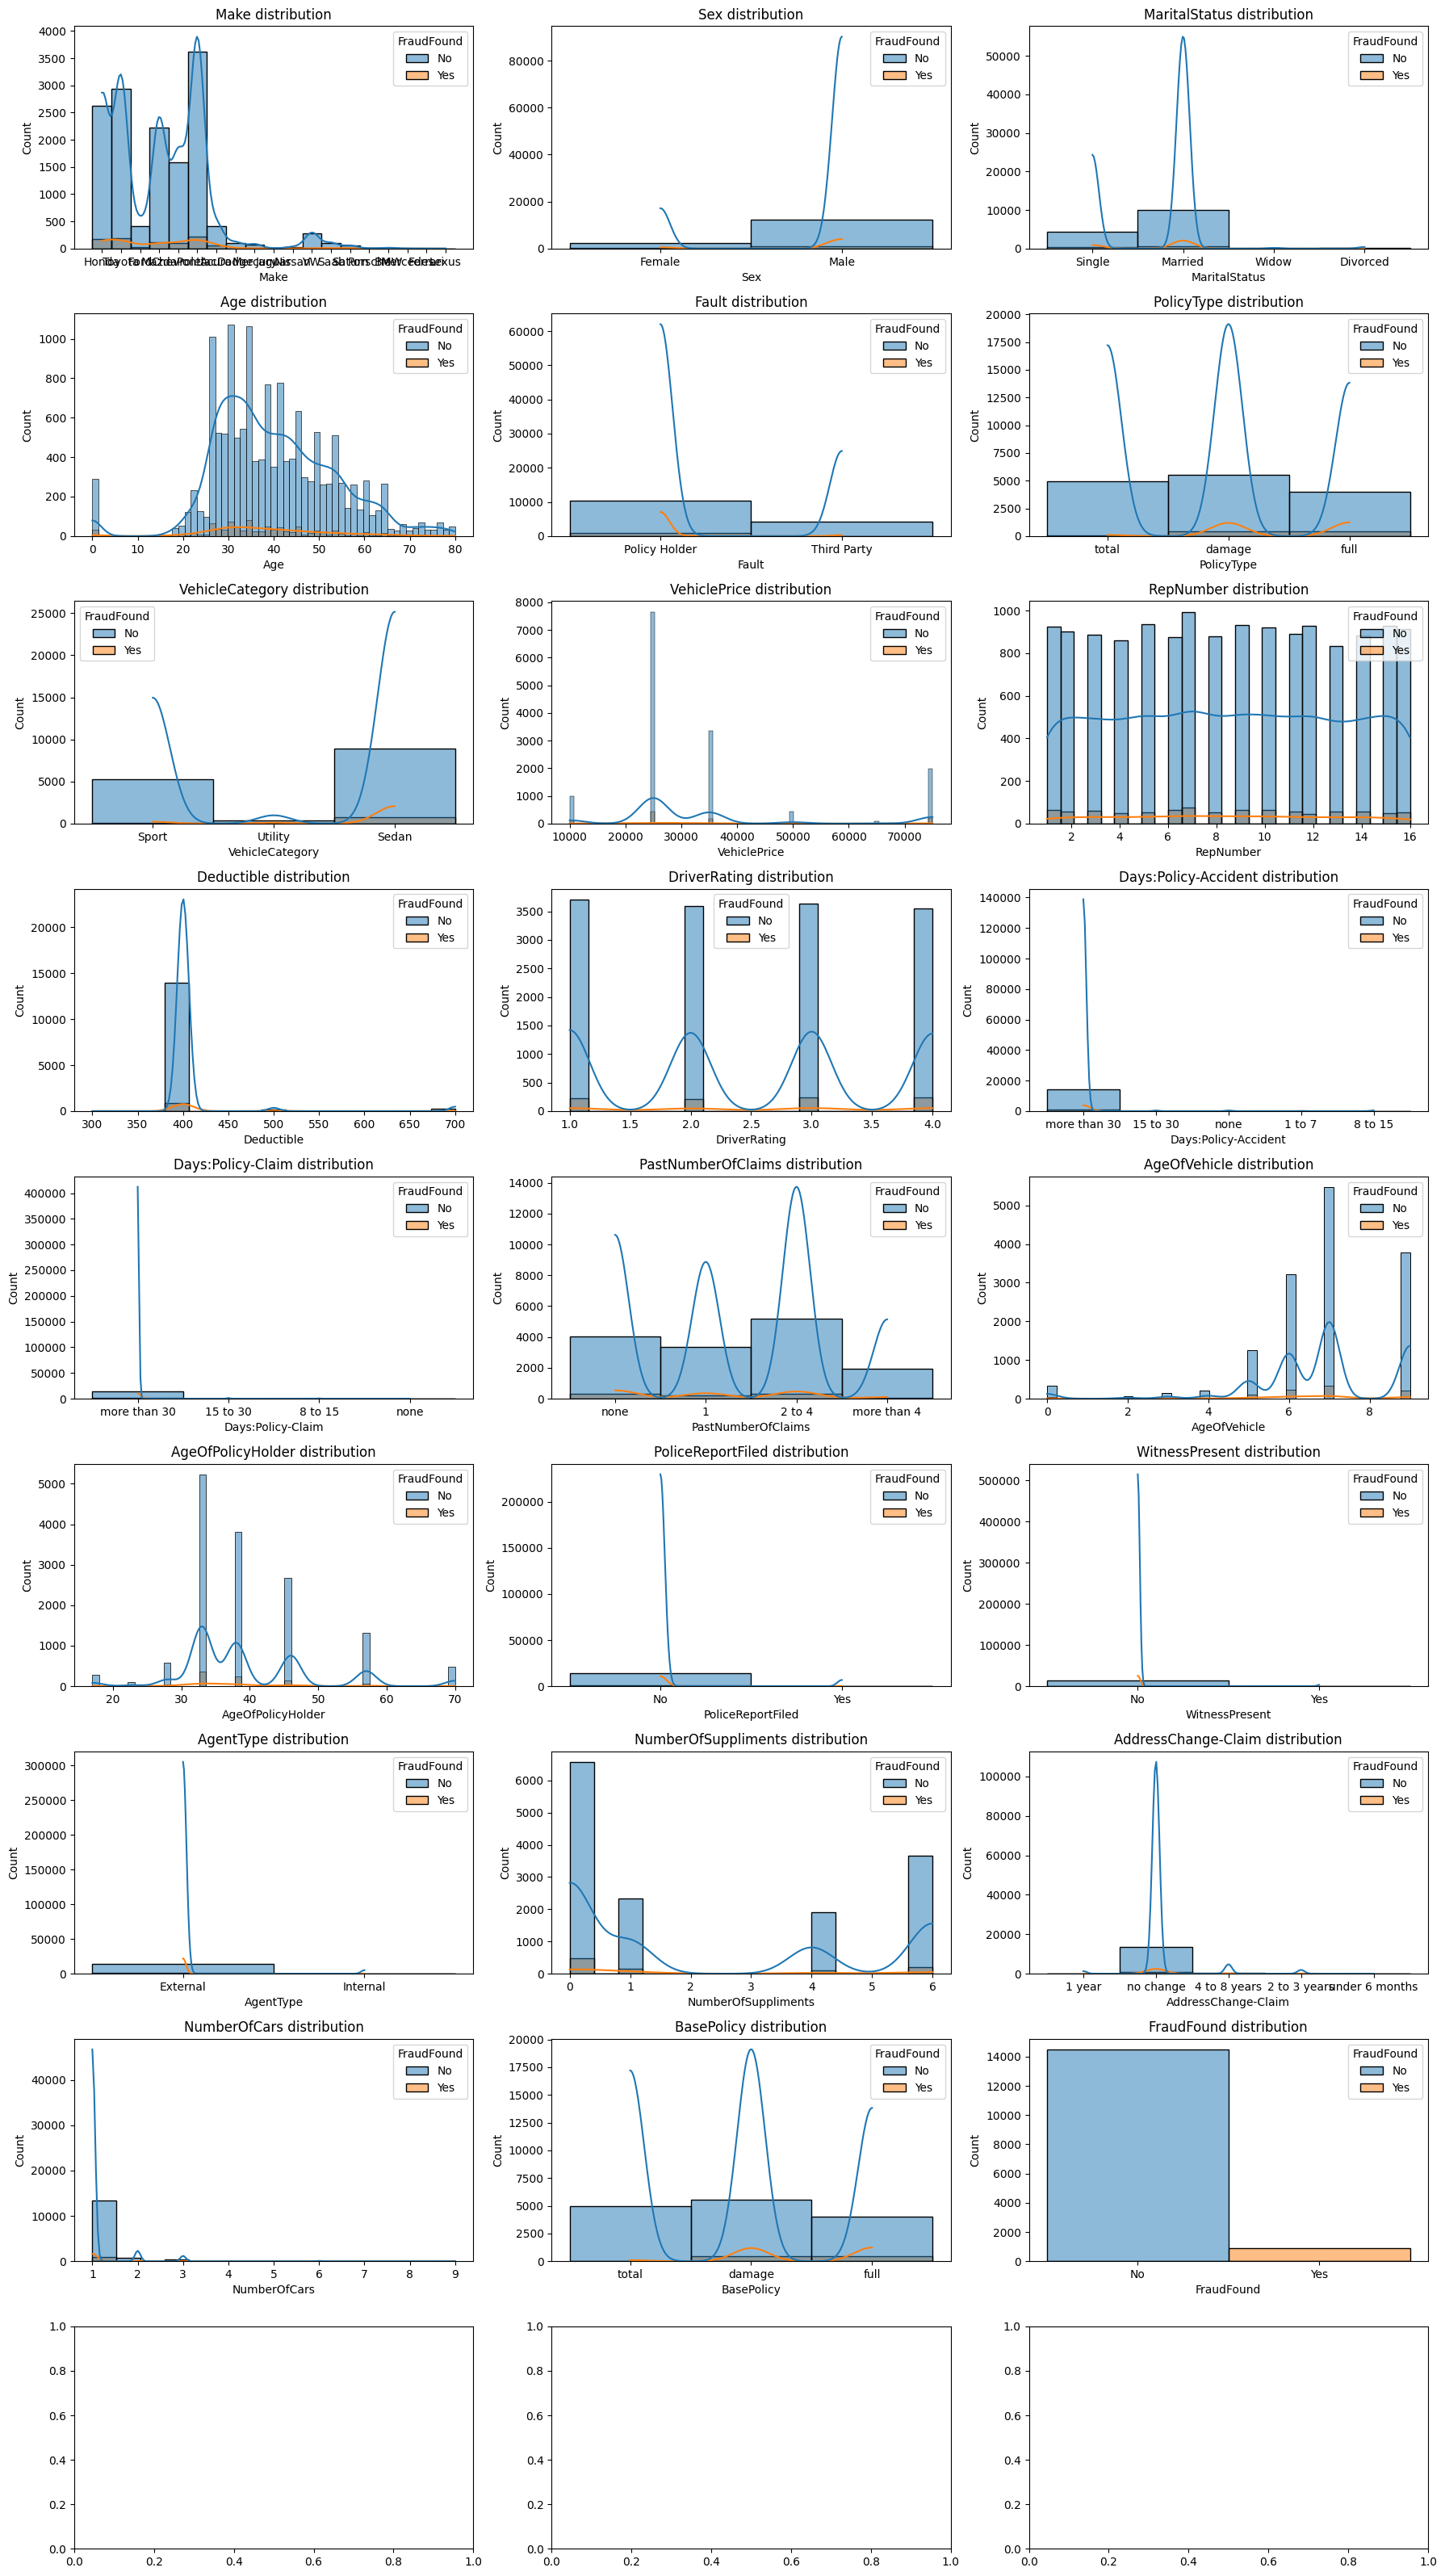

In [648]:
numerical_features = khus_calclaims_df.columns
fig, axes = plt.subplots(nrows = len(numerical_features) // 3 + 1, ncols=3, figsize=(18, 4 * len(numerical_features) // 3))
for i, feature in enumerate(numerical_features):
    row, col = i // 3, i % 3
    sns.histplot(data=khus_calclaims_df, x=feature, hue="FraudFound", ax=axes[row, col], kde=True)
    axes[row, col].set_title(f"{feature} distribution")
plt.tight_layout()
plt.show()

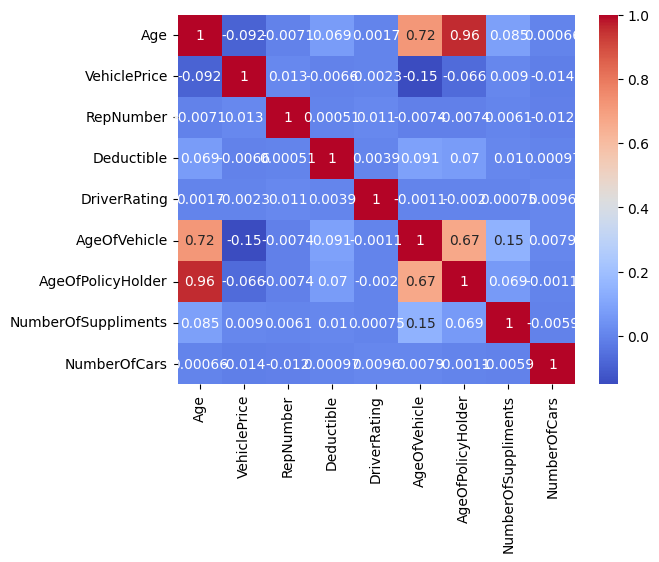

In [649]:
sns.heatmap(khus_calclaims_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.savefig("H:\\GitHub\\ml-fraud-detection\\figs\\corr.png")

In [650]:
y = khus_calclaims_df["FraudFound"]
x = khus_calclaims_df.drop("FraudFound", axis=1)

In [651]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

In [652]:
categorical_features = x_train.select_dtypes(include=["object"]).columns
numerical_features = x_train.select_dtypes(exclude=["object"]).columns

print(f"categorical_featuren:\n{list(categorical_features)}\n\nnumerical_features:\n{list(numerical_features)}")

categorical_featuren:
['Make', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'Days:Policy-Accident', 'Days:Policy-Claim', 'PastNumberOfClaims', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'AddressChange-Claim', 'BasePolicy']

numerical_features:
['Age', 'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'NumberOfCars']


In [653]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(drop="first", sparse_output=False)


def ohe_new_features(df, categorical_features_name, numerical_features_name, encoder):
    new_feats = encoder.transform(df[categorical_features_name])
    new_cols = pd.DataFrame(new_feats, columns=encoder.get_feature_names_out(categorical_features_name))    
    df = df.reset_index(drop=True)
    new_df = pd.concat([df[numerical_features_name], new_cols], axis=1)
    return new_df


onehot_encoder.fit(x_train[categorical_features])

x_train_encoded = ohe_new_features(x_train, categorical_features, numerical_features, onehot_encoder)
x_test_encoded = ohe_new_features(x_test, categorical_features, numerical_features, onehot_encoder)

x_train_encoded

,Age,VehiclePrice,RepNumber,Deductible,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,NumberOfCars,Make_BMW,...,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,AddressChange-Claim_2 to 3 years,AddressChange-Claim_4 to 8 years,AddressChange-Claim_no change,AddressChange-Claim_under 6 months,BasePolicy_full,BasePolicy_total
0,23,25000,6,400,4,6,28,6,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,34,25000,4,400,1,6,33,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,45,50000,6,400,4,7,38,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,25000,13,400,1,7,38,6,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,28,10000,13,400,1,5,33,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12331,30,75000,6,400,3,7,33,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12332,35,25000,3,400,4,7,33,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12333,41,10000,8,400,1,7,38,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12334,29,25000,10,400,2,6,33,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [654]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

all_features = x_train_encoded.columns
x_train_processed = x_train_encoded.copy(deep=True)
x_train_processed[all_features] = standard_scaler.fit_transform(x_train_encoded[all_features])

x_test_processed = x_test_encoded.copy(deep=True)
x_test_processed[all_features] = standard_scaler.transform(x_test_encoded[all_features])

x_train_processed

,Age,VehiclePrice,RepNumber,Deductible,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,NumberOfCars,Make_BMW,...,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,AddressChange-Claim_2 to 3 years,AddressChange-Claim_4 to 8 years,AddressChange-Claim_no change,AddressChange-Claim_under 6 months,BasePolicy_full,BasePolicy_total
0,-1.249814,-0.504881,-0.529498,-0.17736,1.348554,-0.471913,-1.147111,1.485333,-0.248746,-0.031204,...,-0.626609,6.013038,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,-0.695017
1,-0.434568,-0.504881,-0.964161,-0.17736,-1.332039,-0.471913,-0.647712,0.701140,-0.248746,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,1.438813
2,0.380677,0.866186,-0.529498,-0.17736,1.348554,0.091696,-0.148314,-0.867247,4.411138,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,-0.695017
3,0.010111,-0.504881,0.991820,-0.17736,-1.332039,0.091696,-0.148314,1.485333,-0.248746,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,1.438813
4,-0.879247,-1.327521,0.991820,-0.17736,-1.332039,-1.035523,-0.647712,-0.867247,-0.248746,-0.031204,...,1.595890,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,1.581004,-0.695017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12331,-0.731021,2.237253,-0.529498,-0.17736,0.455023,0.091696,-0.647712,-0.867247,4.411138,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,1.438813
12332,-0.360455,-0.504881,-1.181492,-0.17736,1.348554,0.091696,-0.647712,0.701140,-0.248746,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,1.581004,-0.695017
12333,0.084224,-1.327521,-0.094836,-0.17736,-1.332039,0.091696,-0.148314,-0.867247,-0.248746,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,1.581004,-0.695017
12334,-0.805134,-0.504881,0.339827,-0.17736,-0.438508,-0.471913,-0.647712,-0.867247,-0.248746,-0.031204,...,-0.626609,-0.166305,-0.075544,-0.129673,-0.139053,-0.209781,0.279692,-0.01801,-0.632509,-0.695017


In [655]:
y_train_processed = y_train.replace({"Yes": 1, "No": 0})
y_test_processed = y_test.replace({"Yes": 1, "No": 0})
y_train_processed

8294     0
9591     0
14227    0
14863    0
6994     0
        ..
2829     0
6250     0
5044     0
10277    0
14468    0
Name: FraudFound, Length: 12336, dtype: int64

In [656]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

models = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=42),
    "DesTree": DecisionTreeClassifier(random_state=42),
    "RandFor": RandomForestClassifier(random_state=42, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "GradBoost": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(probability=True, random_state=42),
    "KNeighb": KNeighborsClassifier(n_neighbors=5),
    "NaiveBaes": GaussianNB(),
    "Perc": MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    results[name] = cv_scores.mean()

In [657]:
from catboost import CatBoostClassifier, Pool
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, make_scorer

catboost_x_train, catboost_x_test, catboost_y_train, catboost_y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

cat_features = catboost_x_train.columns[np.where(catboost_x_train.dtypes == object)[0]].values.tolist()

catboost_train_pool = Pool(catboost_X_train, catboost_y_train, cat_features=cat_features)
catboost_test_pool = Pool(catboost_X_test, catboost_y_test, cat_features=cat_features)

def catboost_evaluate(**__param_space):
    __param_space["depth"] = int(__param_space["depth"])
    __param_space["iterations"] = int(__param_space["iterations"])
    __param_space["border_count"] = int(__param_space["border_count"])
    model = CatBoostClassifier(
        **__param_space,
        allow_writing_files=False,
        eval_metric="NormalizedGini",
        random_seed=42,
        verbose=False
    )

    model.fit(catboost_train_pool, eval_set=catboost_test_pool, early_stopping_rounds=50)
    y_pred_proba = model.predict_proba(catboost_X_test)[:, 1]
    roc_auc = roc_auc_score(catboost_y_test, y_pred_proba)

    return roc_auc

pbounds = {
    "iterations": (10, 3000),
    "learning_rate": (1e-3, 1),
    "depth": (1, 16),
    "l2_leaf_reg": (0, 10),
    "border_count": (1, 65535),
    "random_strength": (1e-9, 10),
    "bagging_temperature": (0, 10),
}

optimizer = BayesianOptimization(
    f=catboost_evaluate,
    pbounds=pbounds,
    verbose=1,
    random_state=42,
)

optimizer.maximize(init_points=50, n_iter=100)

best_params = optimizer.max["params"]
best_params["depth"] = int(best_params["depth"])
best_params["iterations"] = int(best_params["iterations"])
best_params["border_count"] = int(best_params["border_count"])

print(f"Best params: {best_params}")

optimized_catboost = CatBoostClassifier(
    **best_params,
    allow_writing_files=False,
    eval_metric="NormalizedGini",
    random_seed=42,
    verbose=False
)

optimized_catboost.fit(catboost_train_pool, eval_set=catboost_test_pool, early_stopping_rounds=50)

|   iter    |  target   | baggin... | border... |   depth   | iterat... | l2_lea... | learni... | random... |
-------------------------------------------------------------------------------------------------------------
| 3         | 0.8279    | 1.818     | 1.202e+04 | 5.564     | 1.579e+03 | 4.319     | 0.2919    | 6.119     |
| 21        | 0.8298    | 9.624     | 1.65e+04  | 8.459     | 909.6     | 2.848     | 0.03785   | 6.096     |
| 25        | 0.8324    | 0.4078    | 3.872e+04 | 11.16     | 59.6      | 5.121     | 0.2273    | 6.452     |
| 31        | 0.8344    | 5.487     | 4.534e+04 | 10.78     | 680.6     | 7.122     | 0.238     | 3.254     |
| 40        | 0.8352    | 9.132     | 3.351e+04 | 8.523     | 2.397e+03 | 6.5       | 0.7023    | 7.958     |
| 148       | 0.8358    | 2.503     | 4.428e+04 | 13.02     | 2.798e+03 | 4.193     | 0.24      | 8.367     |
Best params: {'bagging_temperature': 2.5029085594691503, 'border_count': 44282, 'depth': 13, 'iterations': 2797, 'l2_lea

In [658]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    if isinstance(y_pred, np.ndarray) and np.issubdtype(y_pred.dtype, np.integer):
        y_pred = y_pred
    else:
        y_pred = y_pred.replace({"No": 0, "Yes": 1}) if isinstance(y_pred, pd.Series) else [0 if pred == "No" else 1 for pred in y_pred]

    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    gini = 2 * roc_auc - 1

    print(f"\nModel name: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Gini: {gini:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "gini": gini
    }

evaluation_results = []

for name, model in models.items():
    model.fit(x_train_processed, y_train_processed)
    result = evaluate_model(model, x_test_processed, y_test_processed, name)
    evaluation_results.append(result)

optimized_catboost_result = evaluate_model(optimized_catboost, catboost_x_test, catboost_y_test.replace({"Yes": 1, "No": 0}), "CatBoost")
evaluation_results.append(optimized_catboost_result)

results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index("model")
results_df = results_df.sort_values(by="gini", ascending=False)

print(results_df)


Model name: LogReg
Accuracy: 0.9397
Precision: 0.3333
Recall: 0.0054
F1 Score: 0.0106
ROC AUC: 0.8009
Gini: 0.6018

Confusion Matrix:
[[2897    2]
 [ 184    1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.33      0.01      0.01       185

    accuracy                           0.94      3084
   macro avg       0.64      0.50      0.49      3084
weighted avg       0.90      0.94      0.91      3084


Model name: DesTree
Accuracy: 0.8891
Precision: 0.1542
Recall: 0.1892
F1 Score: 0.1699
ROC AUC: 0.5615
Gini: 0.1230

Confusion Matrix:
[[2707  192]
 [ 150   35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2899
           1       0.15      0.19      0.17       185

    accuracy                           0.89      3084
   macro avg       0.55      0.56      0.56      3084
weighted avg       0.90     

In [659]:
results_df

,accuracy,precision,recall,f1,roc_auc,gini
model,,,,,,
CatBoost,0.940337,0.666667,0.010811,0.021277,0.835836,0.671672
GradBoost,0.941634,1.000000,0.027027,0.052632,0.814864,0.629729
LogReg,0.939689,0.333333,0.005405,0.010638,0.800889,0.601779
AdaBoost,0.935149,0.105263,0.010811,0.019608,0.796683,0.593366
RandFor,0.940661,0.625000,0.027027,0.051813,0.785418,0.570836
Perc,0.914397,0.193798,0.135135,0.159236,0.748470,0.496939
SVM,0.940986,1.000000,0.016216,0.031915,0.731578,0.463155
KNeighb,0.935798,0.314286,0.059459,0.100000,0.635526,0.271052
NaiveBaes,0.098898,0.060041,0.956757,0.112991,0.614126,0.228252


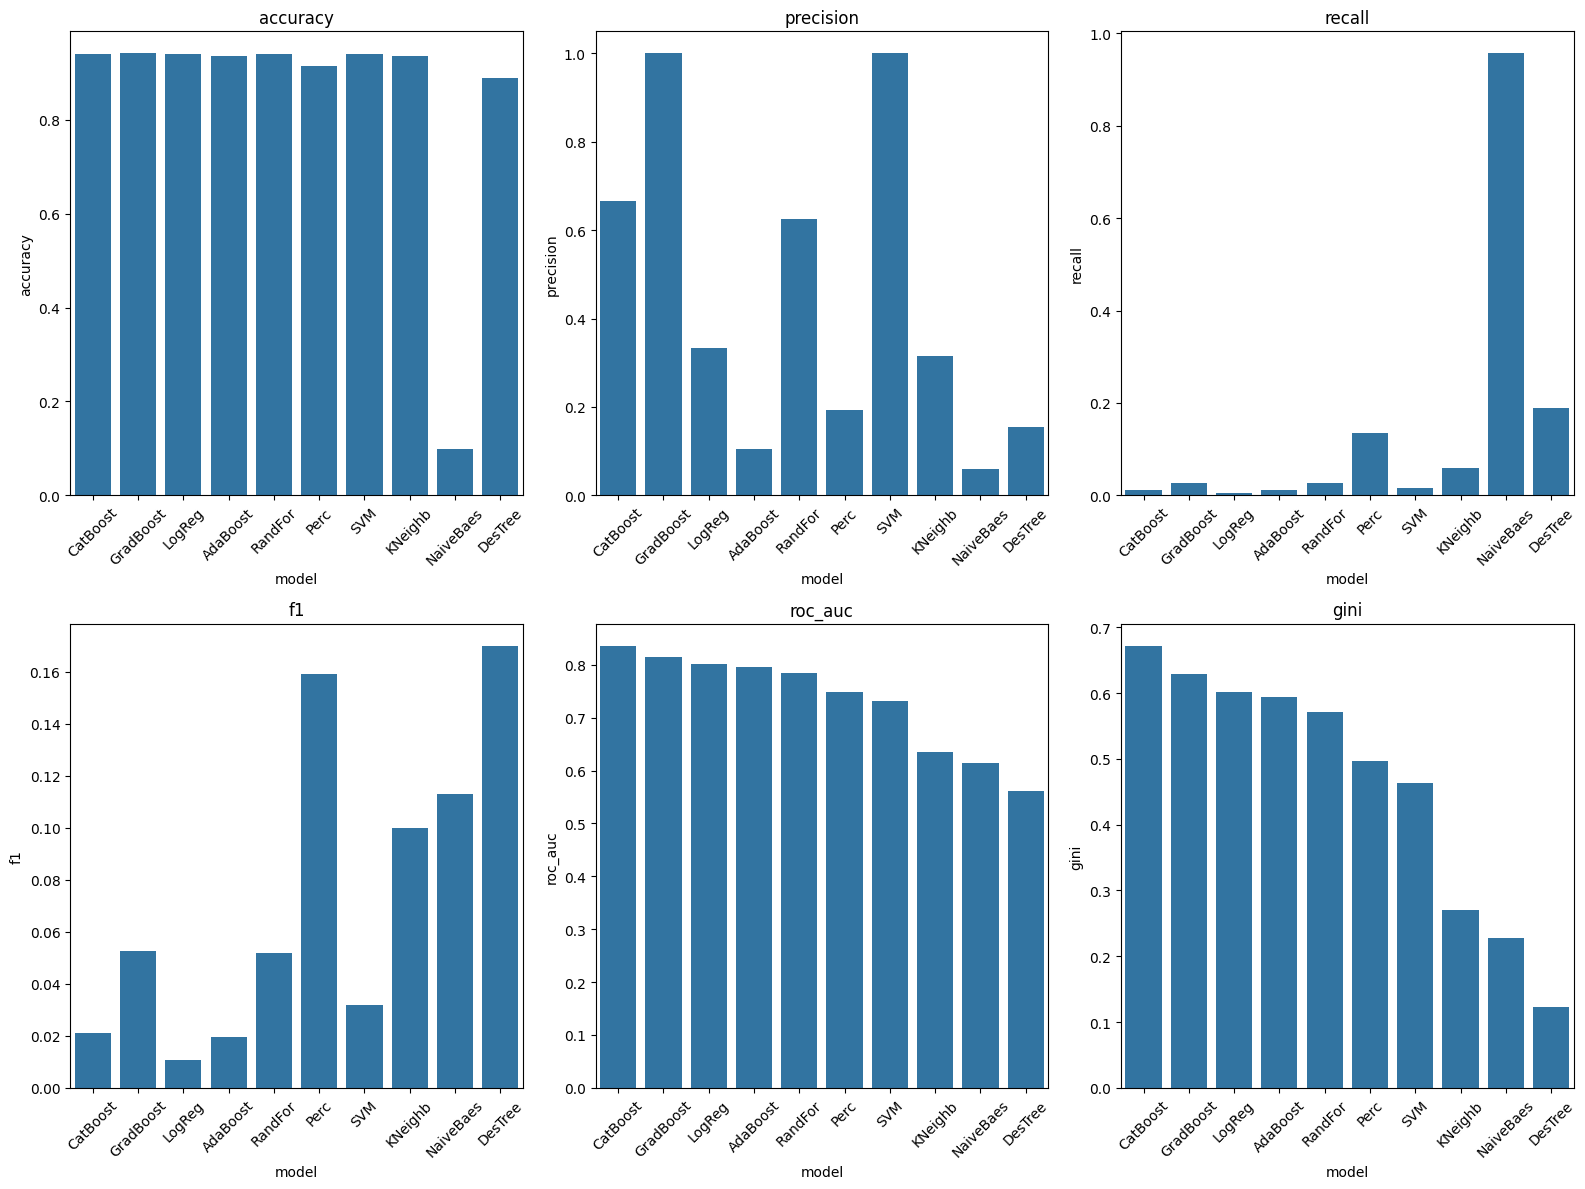

In [660]:
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc", "gini"]
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=results_df.index, y=results_df[metric])
    plt.title(f'{metric}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [661]:
numerical_features = [i for i, feature in enumerate(x_train.columns) if x_train[feature].dtype == "int64"]
numerical_features

[3, 7, 8, 9, 10, 14, 15, 19, 21]

In [662]:
from imblearn.over_sampling import SMOTENC

categorical_features = [i for i, feature in enumerate(x_train.columns) if x_train[feature].dtype == "object"]

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

x_train_resampled, y_train_resampled = smote_nc.fit_resample(x_train, y_train)

pd.Series(y_train_resampled).value_counts(normalize=True)

FraudFound
No     0.5
Yes    0.5
Name: proportion, dtype: float64

In [663]:
onehot_encoder_smote = OneHotEncoder(drop="first", sparse_output=False)

categorical_features = x_train_resampled.select_dtypes(include=["object"]).columns
numerical_features = x_train_resampled.select_dtypes(exclude=["object"]).columns

onehot_encoder_smote.fit(x_train_resampled[categorical_features])

x_train_resampled_encoded = ohe_new_features(x_train_resampled, categorical_features, numerical_features, onehot_encoder_smote)
x_test_resampled_encoded = ohe_new_features(x_test, categorical_features, numerical_features, onehot_encoder_smote)

x_train_resampled_encoded

,Age,VehiclePrice,RepNumber,Deductible,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,NumberOfCars,Make_BMW,...,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,AddressChange-Claim_2 to 3 years,AddressChange-Claim_4 to 8 years,AddressChange-Claim_no change,AddressChange-Claim_under 6 months,BasePolicy_full,BasePolicy_total
0,23,25000,6,400,4,6,28,6,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,34,25000,4,400,1,6,33,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,45,50000,6,400,4,7,38,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,25000,13,400,1,7,38,6,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,28,10000,13,400,1,5,33,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23191,43,50000,4,400,2,7,38,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23192,47,10000,7,400,1,8,46,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
23193,33,25000,5,400,2,6,33,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
23194,66,25000,4,400,1,7,70,5,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [664]:
standard_scaler_smote = StandardScaler()

x_train_resampled_processed = x_train_resampled_encoded.copy(deep=True)
x_train_resampled_processed[all_features] = standard_scaler_smote.fit_transform(x_train_resampled_encoded[all_features])

x_test_resampled_processed = x_test_resampled_encoded.copy(deep=True)
x_test_resampled_processed[all_features] = standard_scaler_smote.transform(x_test_resampled_encoded[all_features])

x_train_resampled_processed

,Age,VehiclePrice,RepNumber,Deductible,DriverRating,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,NumberOfCars,Make_BMW,...,PastNumberOfClaims_none,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,AddressChange-Claim_2 to 3 years,AddressChange-Claim_4 to 8 years,AddressChange-Claim_no change,AddressChange-Claim_under 6 months,BasePolicy_full,BasePolicy_total
0,-1.161511,-0.522318,-0.480528,-0.214473,1.593222,-0.336644,-1.086888,1.748122,-0.219414,-0.027082,...,-0.739956,8.298643,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,-0.803839,-0.463774
1,-0.358987,-0.522318,-0.934470,-0.214473,-1.258717,-0.336644,-0.592158,0.903896,-0.219414,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,-0.803839,2.156222
2,0.443537,0.746927,-0.480528,-0.214473,1.593222,0.215020,-0.097427,-0.784556,5.557580,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,-0.803839,-0.463774
3,0.078753,-0.522318,1.108270,-0.214473,-1.258717,0.215020,-0.097427,1.748122,-0.219414,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,-0.803839,2.156222
4,-0.796728,-1.283864,1.108270,-0.214473,-1.258717,-0.888308,-0.592158,-0.784556,-0.219414,-0.027082,...,1.351432,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,1.244030,-0.463774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23191,0.297624,0.746927,-0.934470,-0.214473,-0.308071,0.215020,-0.097427,-0.784556,-0.219414,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,-0.803839,-0.463774
23192,0.589451,-1.283864,-0.253557,-0.214473,-1.258717,0.766683,0.694141,-0.784556,-0.219414,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,1.244030,-0.463774
23193,-0.431944,-0.522318,-0.707499,-0.214473,-0.308071,-0.336644,-0.592158,-0.784556,-0.219414,-0.027082,...,1.351432,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,1.244030,-0.463774
23194,1.975629,-0.522318,-0.934470,-0.214473,-1.258717,0.215020,3.068845,1.326009,2.669083,-0.027082,...,-0.739956,-0.120502,-0.055017,-0.094195,-0.202418,-0.153357,0.271001,-0.013133,1.244030,-0.463774


In [665]:
y_train_resampled_processed = y_train_resampled.replace({"Yes": 1, "No": 0})
y_test_resampled_processed = y_test.replace({"Yes": 1, "No": 0})
y_train_resampled_processed

0        0
1        0
2        0
3        0
4        0
        ..
23191    1
23192    1
23193    1
23194    1
23195    1
Name: FraudFound, Length: 23196, dtype: int64

In [666]:
models = {
    "LogReg": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "DesTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RandFor": RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "GradBoost": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),
    "KNeighb": KNeighborsClassifier(n_neighbors=5),
    "NaiveBaes": GaussianNB(),
    "Perc": MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, x_train_resampled_processed, y_train_resampled_processed, cv=cv, scoring="roc_auc", n_jobs=-1)
    results[name] = cv_scores.mean()

In [667]:
catboost_x_train_resampled, catboost_x_test_resampled, catboost_y_train_resampled, catboost_y_test_resampled = x_train_resampled, x_test, y_train_resampled, y_test

cat_features = catboost_x_train_resampled.columns[np.where(catboost_x_train_resampled.dtypes != float)[0]].values.tolist()

catboost_train_pool = Pool(catboost_x_train_resampled, catboost_y_train_resampled, cat_features=cat_features)
catboost_test_pool = Pool(catboost_x_test_resampled, catboost_y_test_resampled, cat_features=cat_features)


def catboost_evaluate_resampled(**__param_space):
    __param_space["depth"] = int(__param_space["depth"])
    __param_space["iterations"] = int(__param_space["iterations"])
    __param_space["border_count"] = int(__param_space["border_count"])
    model = CatBoostClassifier(
        **__param_space,
        loss_function="Logloss",
        eval_metric="NormalizedGini",
        verbose=0,
        random_seed=42,
        cat_features=cat_features
    )

    model.fit(catboost_train_pool, eval_set=catboost_test_pool, early_stopping_rounds=50)
    y_pred_proba = model.predict_proba(catboost_x_test_resampled)[:, 1]
    roc_auc = roc_auc_score(catboost_y_test_resampled, y_pred_proba)

    return roc_auc


optimizer = BayesianOptimization(
    f=catboost_evaluate_resampled,
    pbounds=pbounds,
    verbose=1,
    random_state=42,
)

optimizer.maximize(init_points=50, n_iter=100)

best_params = optimizer.max["params"]
best_params["depth"] = int(best_params["depth"])
best_params["iterations"] = int(best_params["iterations"])
best_params["border_count"] = int(best_params["border_count"])

print(f"Best params: {best_params}")

optimized_catboost_resampled = CatBoostClassifier(
    **best_params,
    allow_writing_files=False,
    eval_metric="NormalizedGini",
    random_seed=42,
    verbose=False
)

optimized_catboost_resampled.fit(catboost_train_pool, eval_set=catboost_test_pool, early_stopping_rounds=50)

|   iter    |  target   | baggin... | border... |   depth   | iterat... | l2_lea... | learni... | random... |
-------------------------------------------------------------------------------------------------------------
| 2         | 0.8061    | 8.662     | 3.939e+04 | 11.62     | 71.55     | 9.699     | 0.8326    | 2.123     |
| 23        | 0.8112    | 9.857     | 1.586e+04 | 11.08     | 2.287e+03 | 2.376     | 0.7285    | 3.678     |
| 59        | 0.8139    | 2.807     | 3.869e+04 | 12.31     | 58.75     | 2.552     | 0.04904   | 5.589     |
Best params: {'bagging_temperature': 2.807157565208249, 'border_count': 38692, 'depth': 12, 'iterations': 58, 'l2_leaf_reg': 2.552397825166822, 'learning_rate': 0.04903928569990929, 'random_strength': 5.588907262009903}


In [668]:
evaluation_results = []

for name, model in models.items():
    model.fit(x_train_resampled_processed, y_train_resampled_processed)
    result = evaluate_model(model, x_test_resampled_processed, y_test_resampled_processed, name)
    evaluation_results.append(result)

optimized_catboost_result = evaluate_model(optimized_catboost_resampled, catboost_x_test_resampled, catboost_y_test_resampled.replace({"Yes": 1, "No": 0}), "CatBoost")
evaluation_results.append(optimized_catboost_result)

results_resampled_df = pd.DataFrame(evaluation_results)
results_resampled_df = results_resampled_df.set_index("model")
results_resampled_df = results_resampled_df.sort_values(by="gini", ascending=False)

print(results_resampled_df)


Model name: LogReg
Accuracy: 0.7156
Precision: 0.1366
Recall: 0.7027
F1 Score: 0.2287
ROC AUC: 0.7690
Gini: 0.5381

Confusion Matrix:
[[2077  822]
 [  55  130]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      2899
           1       0.14      0.70      0.23       185

    accuracy                           0.72      3084
   macro avg       0.56      0.71      0.53      3084
weighted avg       0.92      0.72      0.79      3084


Model name: DesTree
Accuracy: 0.8463
Precision: 0.1467
Recall: 0.3243
F1 Score: 0.2020
ROC AUC: 0.6019
Gini: 0.2038

Confusion Matrix:
[[2550  349]
 [ 125   60]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2899
           1       0.15      0.32      0.20       185

    accuracy                           0.85      3084
   macro avg       0.55      0.60      0.56      3084
weighted avg       0.90     

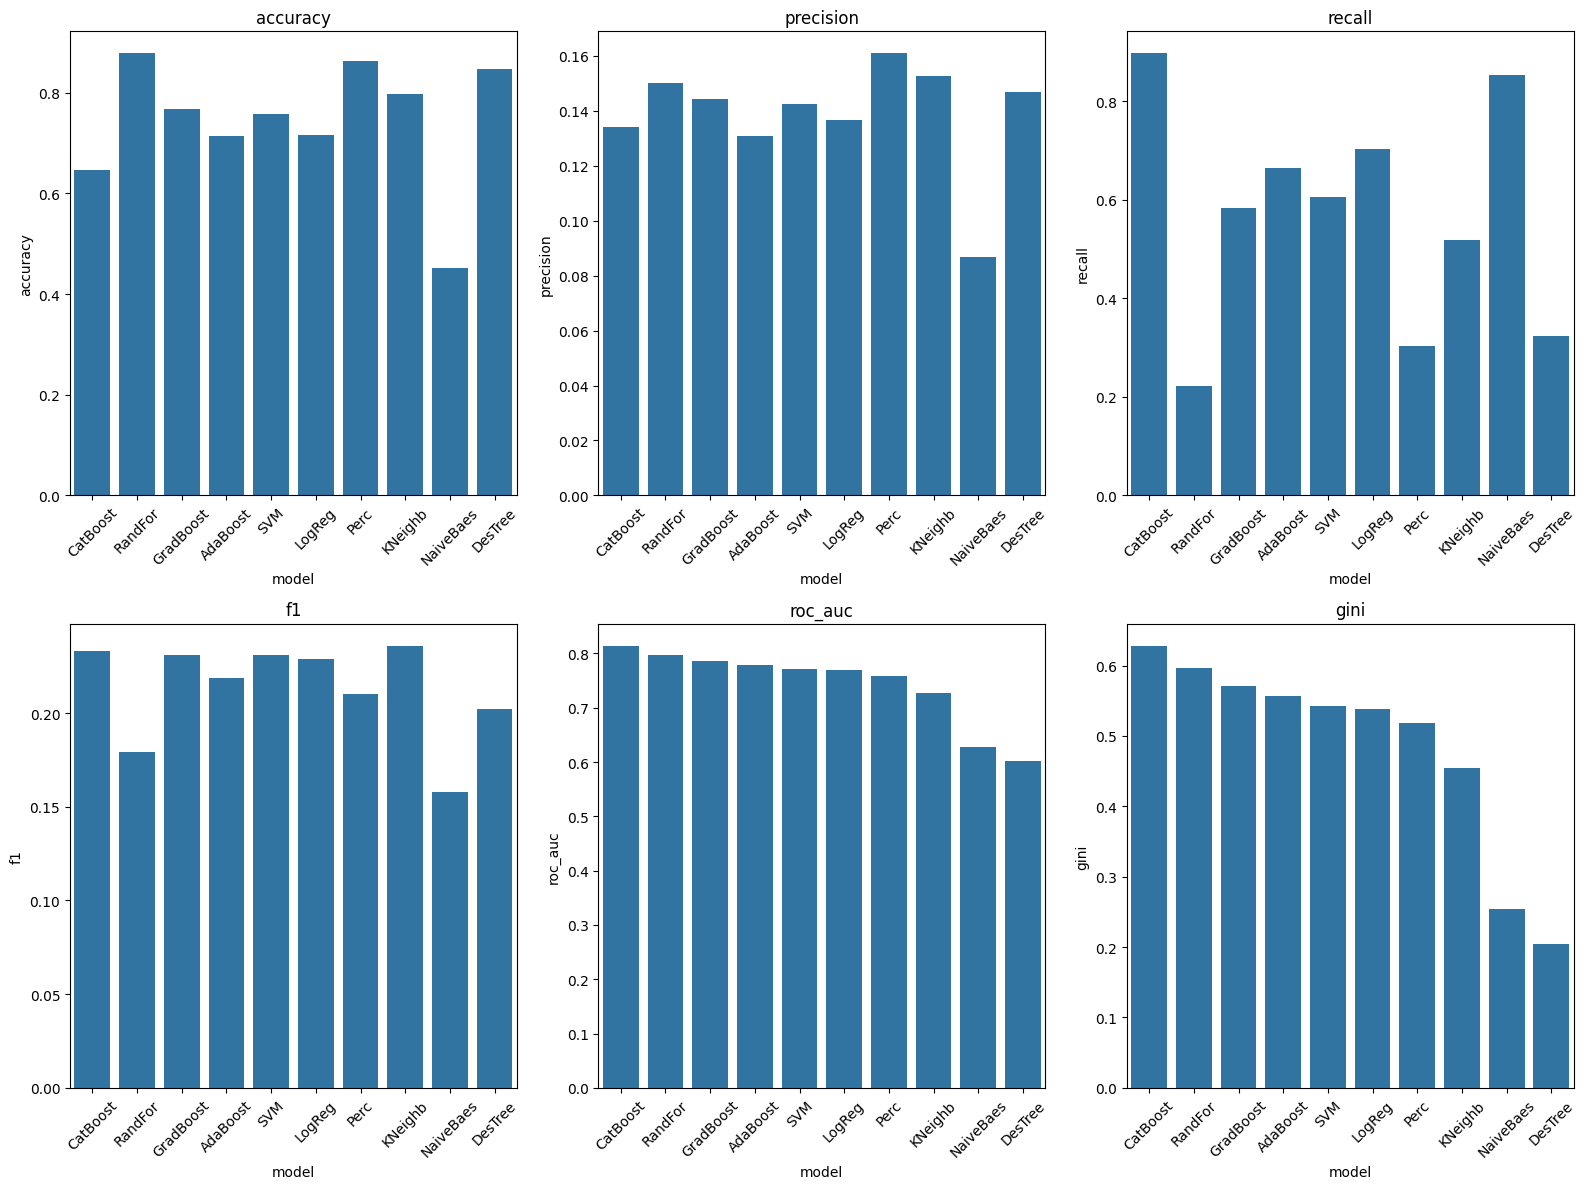

In [669]:
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc", "gini"]
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=results_resampled_df.index, y=results_resampled_df[metric])
    plt.title(f'{metric}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [670]:
import pickle

optimized_catboost_resampled.save_model("H:\\GitHub\\ml-fraud-detection\\models\\catboost_fraud_detection_model_resampled.cbm")
optimized_catboost.save_model("H:\\GitHub\\ml-fraud-detection\\models\\catboost_fraud_detection_model.cbm")

with open("H:\\GitHub\\ml-fraud-detection\\models\\onehotencoder.pkl", "wb") as f:
    pickle.dump(onehot_encoder, f)

with open("H:\\GitHub\\ml-fraud-detection\\models\\scaler.pkl", "wb") as f:
    pickle.dump(standard_scaler, f)

In [671]:
import shap
shap.initjs()

In [737]:
explainer = shap.TreeExplainer(optimized_catboost_resampled)
shap_values = explainer(catboost_x_test)

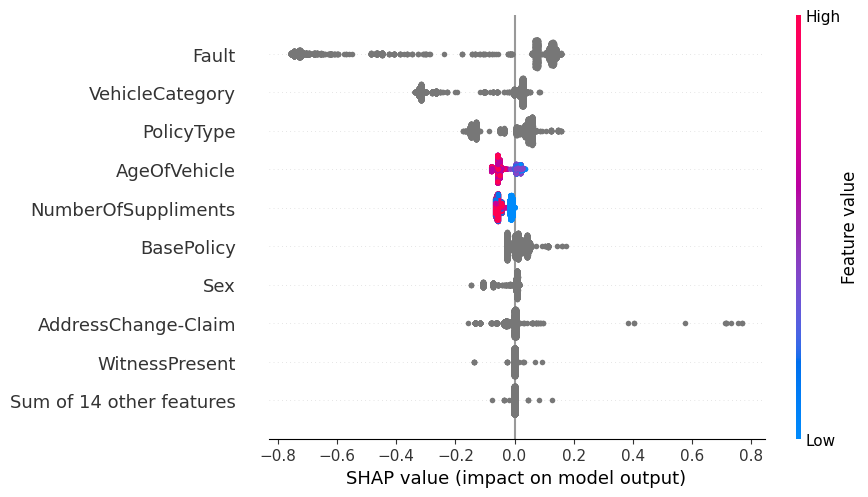

In [738]:
shap.plots.beeswarm(shap_values)

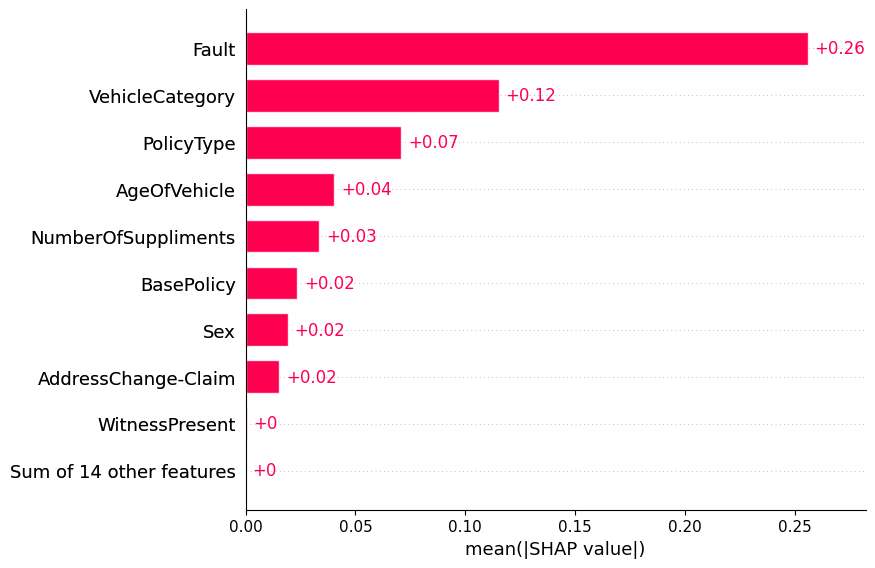

In [739]:
shap.plots.bar(shap_values)

In [740]:
def explain_prediction(model, explainer, input_data):
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)[:, 1][0]
    
    shap_values = explainer.shap_values(input_data)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    feature_importance = pd.DataFrame({
        "feature": input_data.columns,
        "value": input_data.values[0],
        "shap_value": shap_values[0]
    })
    feature_importance = feature_importance.sort_values(by="shap_value", key=abs, ascending=False)
    
    explanation = []
    for _, row in feature_importance.head(5).iterrows():
        feature = row["feature"]
        value = row["value"]
        shap_value = row["shap_value"]
        direction = "increases" if shap_value > 0 else "decreases"
        explanation.append(f"Feature '{feature}' with value {value} {direction} doubts by {abs(shap_value):.4f}")
    
    return {
        "prediction": prediction,
        "probability": float(probability),
        "explanation": explanation,
    }

In [741]:
test_input_data = x_test[y_test == "Yes"].head(1).reset_index().iloc[[-1]].drop("index", axis=1)

In [742]:
test_input_data

,Make,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,...,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy
0,Mazda,Male,Married,35,Policy Holder,full,Sedan,25000,9,400,...,1,7,33,No,No,External,4,no change,1,full


In [743]:
explain_prediction(optimized_catboost, explainer, test_input_data)

{'prediction': array(['No'], dtype=object),
 'probability': 0.20111161790971072,
 'explanation': ["Feature 'Fault' with value Policy Holder increases doubts by 0.1398",
  "Feature 'NumberOfSuppliments' with value 4 decreases doubts by 0.0635",
  "Feature 'PolicyType' with value full increases doubts by 0.0594",
  "Feature 'AgeOfVehicle' with value 7 decreases doubts by 0.0562",
  "Feature 'BasePolicy' with value full increases doubts by 0.0435"]}

In [744]:
optimized_catboost.predict(test_input_data)

array(['No'], dtype=object)

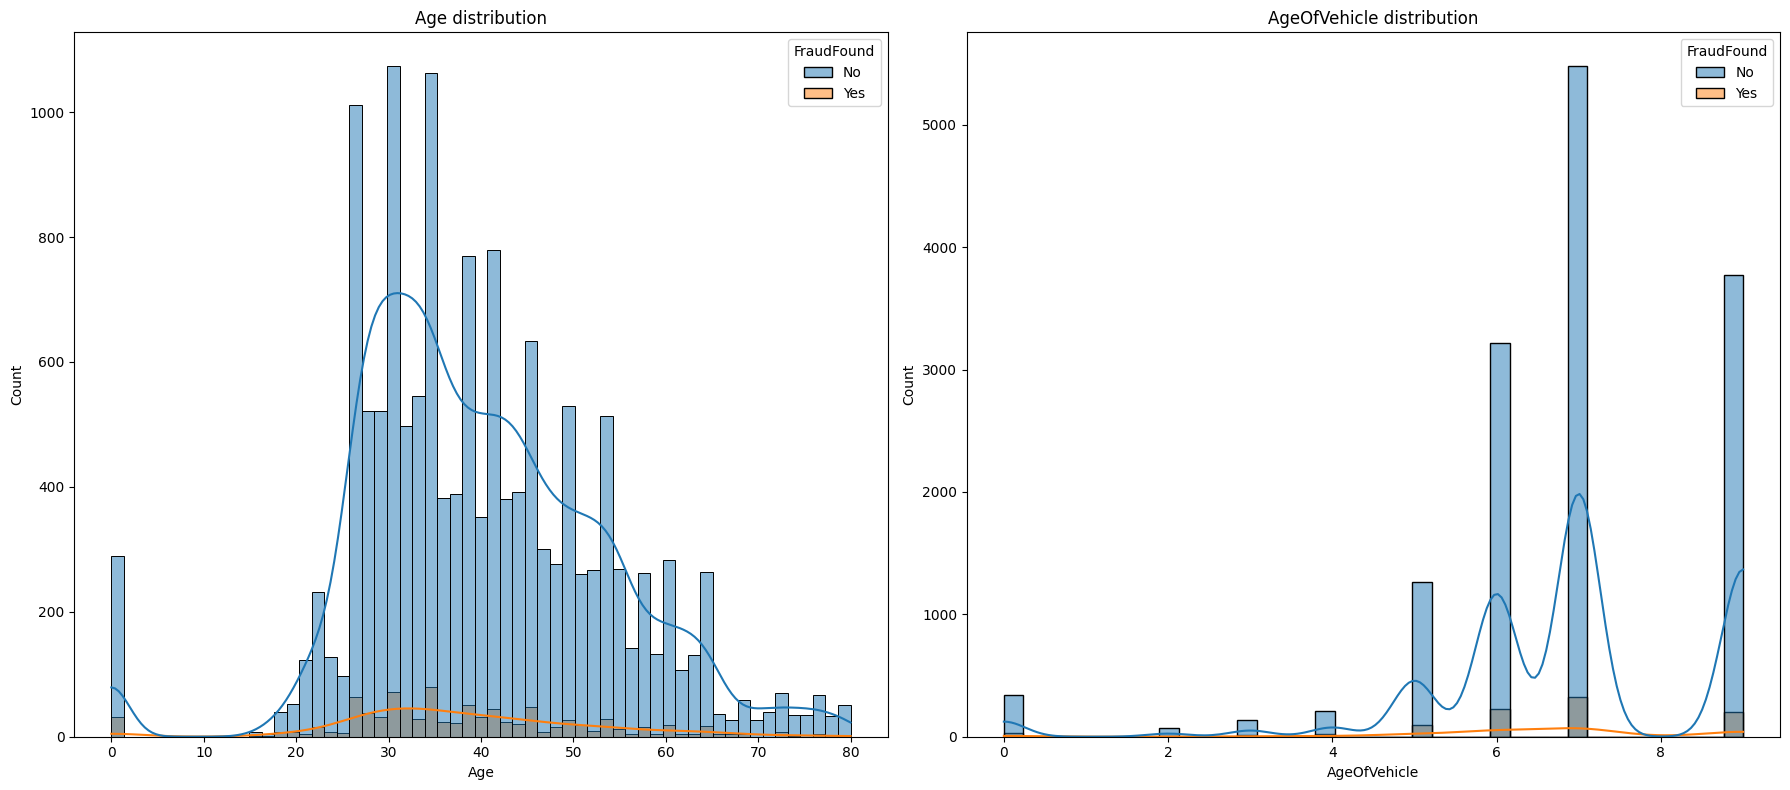

In [745]:
numerical_features = khus_calclaims_df[["Age", "AgeOfVehicle"]].columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4 * len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.histplot(data=khus_calclaims_df, x=feature, hue="FraudFound", ax=axes[i], kde=True)
    axes[i].set_title(f"{feature} distribution")
plt.tight_layout()
plt.show()

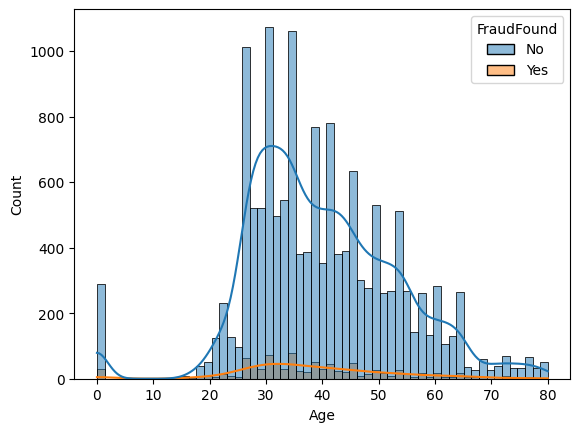

In [691]:
sns.histplot(data=khus_calclaims_df, x="Age", hue="FraudFound", kde=True)
plt.savefig("H:\\GitHub\\ml-fraud-detection\\figs\\age_dist.png")

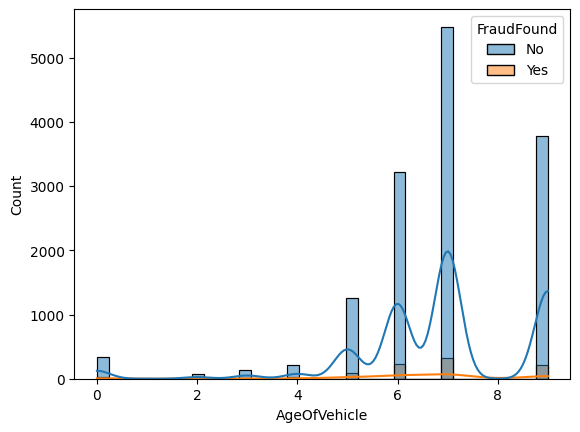

In [692]:
sns.histplot(data=khus_calclaims_df, x="AgeOfVehicle", hue="FraudFound", kde=True)
plt.savefig("H:\\GitHub\\ml-fraud-detection\\figs\\age_veh_dist.png")

In [734]:
both_results_df = pd.concat([results_df, results_resampled_df], keys=["without SMOTE", "with SMOTE"]).reset_index(level=[0])
both_results_df["type"] = both_results_df["level_0"]
both_results_df.drop("level_0", axis=1, inplace=True)

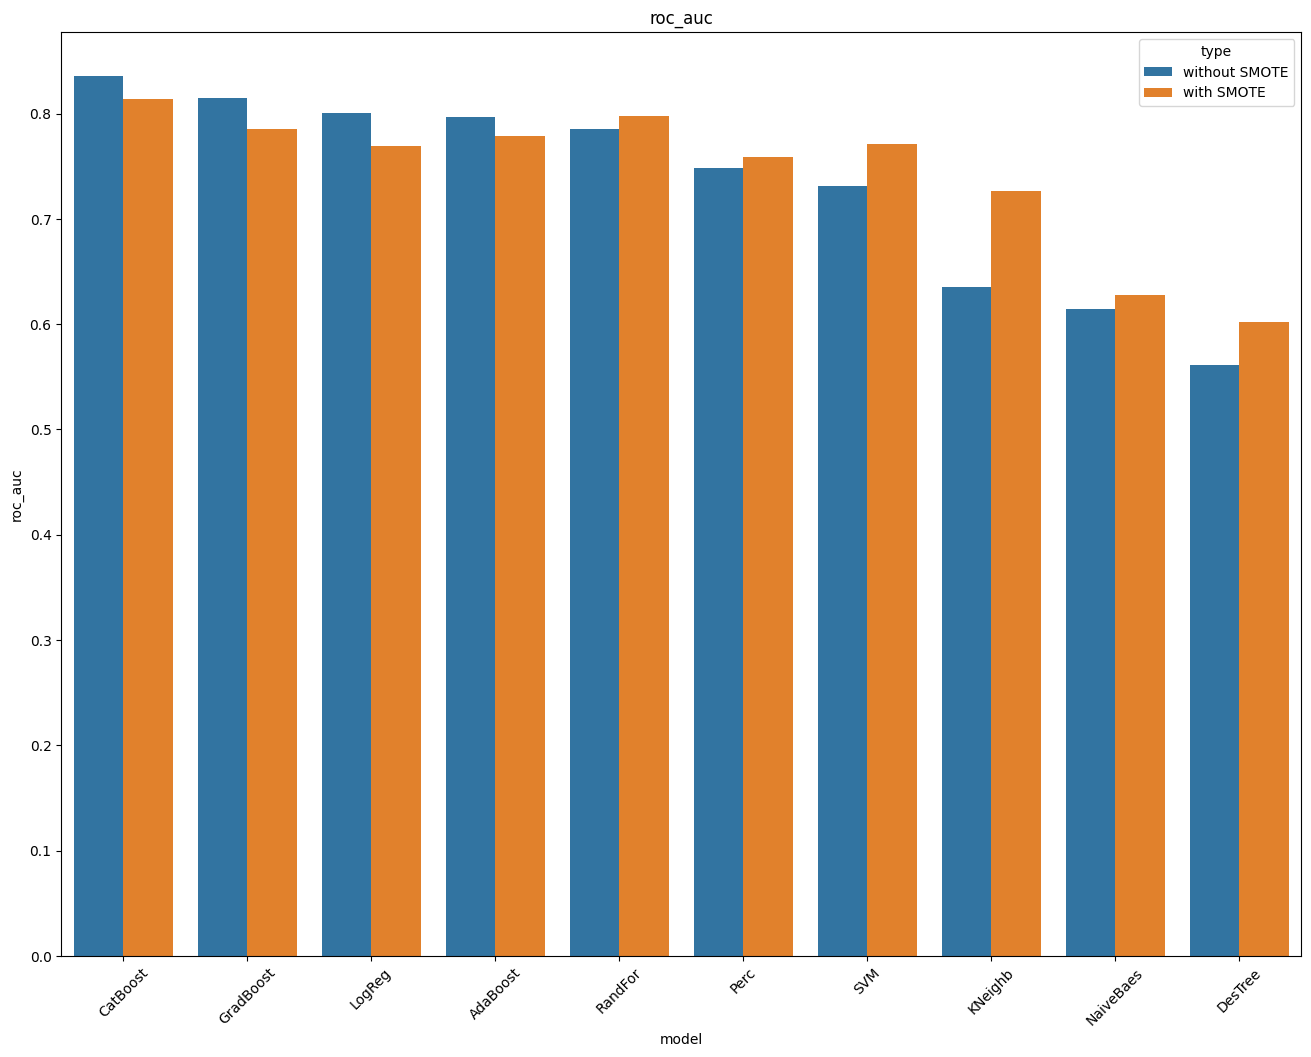

In [735]:
plt.figure(figsize=(16, 12))
sns.barplot(x=both_results_df.index, y=both_results_df["roc_auc"], hue=both_results_df["type"])
plt.title("roc_auc")
plt.xticks(rotation=45)
plt.savefig("H:\\GitHub\\ml-fraud-detection\\figs\\roc_auc_comp.png")

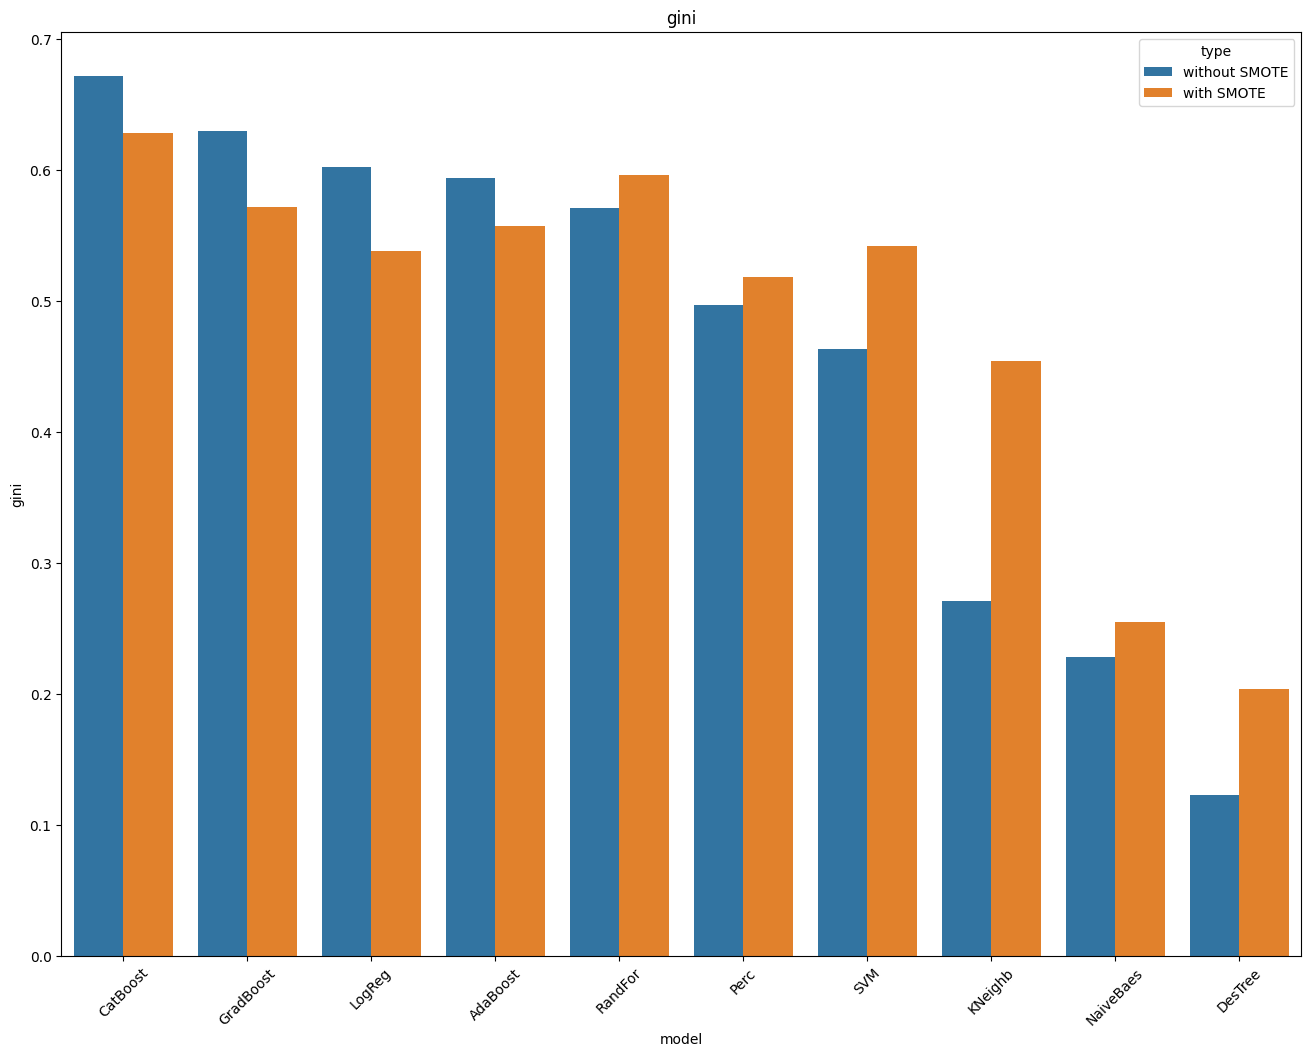

In [736]:
plt.figure(figsize=(16, 12))
sns.barplot(x=both_results_df.index, y=both_results_df["gini"], hue=both_results_df["type"])
plt.title("gini")
plt.xticks(rotation=45)
plt.savefig("H:\\GitHub\\ml-fraud-detection\\figs\\gini_comp.png")